# Importing all necessary modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, datasets, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split as tst

# Reading the dataset

In [2]:
col_l = ['image', 'player']
df = pd.read_csv ('players.csv', usecols=col_l)

im = 128 #Image Shape

images = []
players = []
frames = df.values.tolist()
for i in range(df.shape[0]):
    img = cv2.imread('dataset_\\images\\'+frames[i][1]+'\\'+frames[i][0], 1)
    img = cv2.resize(img,(im, im))
    images.append(img)
    players.append(frames[i][1])

# Defining Features and Labels:

In [3]:
play = set(players)
play = sorted(play)
play = list(play)

for i in range(len(players)):
    players[i] = play.index(players[i])

x = np.array(images)
y = np.array(players)

play

['bhuvneshwar_kumar',
 'dinesh_karthik',
 'hardik_pandya',
 'jasprit_bumrah',
 'k._l._rahul',
 'kedar_jadhav',
 'kuldeep_yadav',
 'mohammed_shami',
 'ms_dhoni',
 'ravindra_jadeja',
 'rohit_sharma',
 'shikhar_dhawan',
 'vijay_shankar',
 'virat_kohli',
 'yuzvendra_chahal']

# Splitting the training and testing data AND Preprocessing It.

In [4]:
x_train, x_test, y_train, y_test = tst(x, y, test_size=0.15, random_state=10)
x_train, x_val, y_train ,  y_val = tst(x_train, y_train, test_size = 0.1, random_state = 10)

x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_val=x_val.astype('float32')

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

num_classes = y_test.shape[1]

# Defining our CNN model

In [5]:
def define_model():
    cnn = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape= x_train[0].shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(filters=64, kernel_size=(2, 2), kernel_constraint=maxnorm(2), padding='same', activation='relu'),
        layers.Conv2D(filters=64, kernel_size=(2, 2), kernel_constraint=maxnorm(2), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=128, kernel_size=(2, 2),  kernel_constraint=maxnorm(2),  padding='same', activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(1000, activation='relu', kernel_constraint=maxnorm(4), 
                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                     bias_regularizer=keras.regularizers.l2(1e-4),
                     activity_regularizer=keras.regularizers.l2(1e-5)),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation='softmax')
    ])

    cnn.compile(
        optimizer= 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return cnn


# Data Augmentation 

In [6]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)

# Defining epochs and Batch Size

In [7]:
epochs = 50
batch_size = 32

# Printing Model Summary

In [8]:
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       3

# Training the Model

In [9]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

# history = model.fit(x_train,y_train, validation_data = (x_val, y_val), batch_size = batch_size, epochs = epochs)

Epoch 1/50
13/13 [==============================] - 11s 871ms/step - loss: 7.9199 - accuracy: 0.0686 - val_loss: 4.4752 - val_accuracy: 0.1429
Epoch 2/50
13/13 [==============================] - 12s 911ms/step - loss: 4.4112 - accuracy: 0.0833 - val_loss: 4.2553 - val_accuracy: 0.1429
Epoch 3/50
13/13 [==============================] - 11s 854ms/step - loss: 4.1974 - accuracy: 0.0858 - val_loss: 4.0697 - val_accuracy: 0.0816
Epoch 4/50
13/13 [==============================] - 11s 813ms/step - loss: 4.0064 - accuracy: 0.0956 - val_loss: 3.8896 - val_accuracy: 0.2245
Epoch 5/50
13/13 [==============================] - 10s 806ms/step - loss: 3.8671 - accuracy: 0.1078 - val_loss: 3.7673 - val_accuracy: 0.2653
Epoch 6/50
13/13 [==============================] - 11s 810ms/step - loss: 3.7205 - accuracy: 0.1422 - val_loss: 3.6192 - val_accuracy: 0.1633
Epoch 7/50
13/13 [==============================] - 11s 876ms/step - loss: 3.5831 - accuracy: 0.1373 - val_loss: 3.5000 - val_accuracy: 0.1429

# Evaluating It's Accuracy

In [10]:
_, acc = model.evaluate(x_test, y_test)
print('Accuracy> %.3f' % (acc * 100.0))

3/3 [==============================] - 0s 85ms/step - loss: 4.3340 - accuracy: 0.4483
Accuracy> 44.828


# Plotting Accuracy Graph

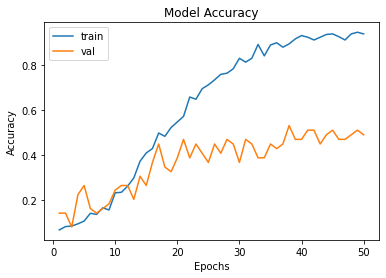

In [11]:
epoch_range=range(1, epochs+1)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Plotting Loss Graph

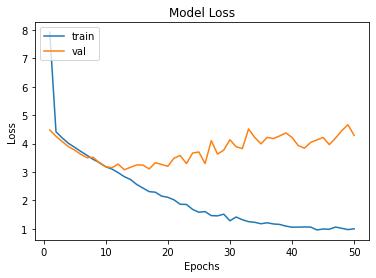

In [12]:
epoch_range=range(1, epochs+1)
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Predicting All testing Data

In [13]:
y_preds=model.predict(x_test)
y_pred_labels = [np.argmax(i) for i in y_preds]
y_test_labels = [np.argmax(i) for i in y_test]

y_test_l = [play[i] for i in y_test_labels]
y_pred_l = [play[i] for i in y_pred_labels]


# Printing Some Testing and Predicted Data 

In [14]:
print("-------------------------------------------------------Original Values-------------------------------------------------------------")
print()
print(y_test_l[:8])
print()
print("-------------------------------------------------------Predicted Values------------------------------------------------------------")
print()
print(y_pred_l[:8])

-------------------------------------------------------Original Values-------------------------------------------------------------

['ms_dhoni', 'rohit_sharma', 'dinesh_karthik', 'dinesh_karthik', 'dinesh_karthik', 'hardik_pandya', 'hardik_pandya', 'k._l._rahul']

-------------------------------------------------------Predicted Values------------------------------------------------------------

['ravindra_jadeja', 'rohit_sharma', 'dinesh_karthik', 'k._l._rahul', 'dinesh_karthik', 'hardik_pandya', 'hardik_pandya', 'k._l._rahul']


# Displaying particular Image with Prediction

In [15]:
def plot_sample(a, b, index):
    plt.figure( figsize = (40, 3) )
    plt.imshow( a[index] )
    plt.title( play[np.argmax(b[index]) ] )
    y_p = model.predict(a)
    
    plt.xlabel("Predicted:  "+play[np.argmax(y_p[index])])

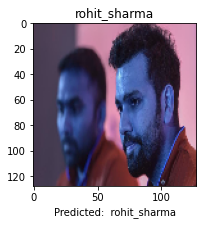

In [16]:
plot_sample(x_test, y_test, 15)



# Defining Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
cm

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 0],
       [0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 8, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]], dtype=int64)

# Plotting Confsion Matrix

Text(69.0, 0.5, 'Truth')

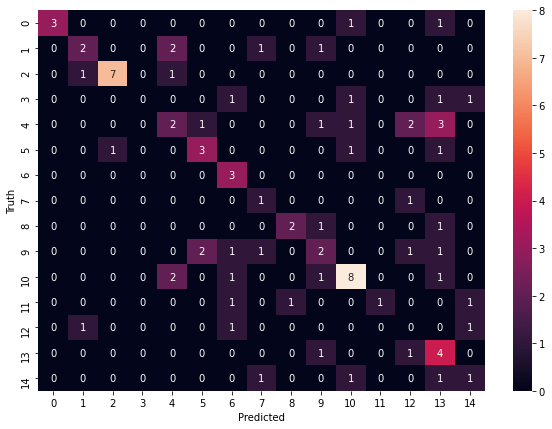

In [18]:
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')


# Detecting and Predicting the Face

bhuvneshwar_kumar


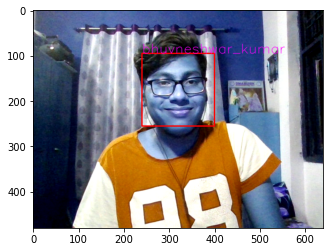

In [19]:
import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)


while True:
    
    ret, frame = cap.read()
    if ret:

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)


        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            face = frame[x: x+w, y: y + h]
            
            if(face.size!=0):
                face = cv2.resize(face, (im, im))
                ar = face.reshape(1, im, im, 3)


                y_pre = model.predict(ar)
                a = np.argmax(y_pre)
                txt = play[a]

                frame = cv2.putText(frame, txt, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 1, cv2.LINE_AA)

        cv2.imshow('img', frame)
        img = frame
        # Stop if  q key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
plt.imshow(img)
cap.release()
print(txt)